# Wildfire Detection System

This notebook gives a detailed analysis of forest fire and predictes the probability of a area to be affected by forest fire.

# Import Libraries and Setup

In [26]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load and Download Dataset

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

try:
    df = pd.read_csv(url, header=1)
    print("Dataset loaded successfully")
except:
    np.random.seed(42)
    n_samples = 244

    data = {
        'Temperature': np.random.normal(32, 8, n_samples),
        'RH': np.random.normal(45, 15, n_samples),
        'Ws': np.random.normal(15, 5, n_samples),
        'Rain': np.random.exponential(2, n_samples),
        'FFMC': np.random.normal(85, 10, n_samples),
        'DMC': np.random.normal(25, 15, n_samples),
        'DC': np.random.normal(150, 50, n_samples),
        'ISI': np.random.normal(8, 4, n_samples),
        'BUI': np.random.normal(35, 20, n_samples),
        'FWI': np.random.normal(15, 10, n_samples),
        'Classes': np.random.choice(['fire', 'not fire'], n_samples, p=[0.48, 0.52])
    }
    df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully
Dataset shape: (246, 14)


# Data Preprocessing and Cleaning

Missing values per column:
day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        1
dtype: int64
Final dataset shape: (242, 14)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 3 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          242 non-null    float64
 1   month        242 non-null    float64
 2   year         242 non-null    float64
 3   Temperature  242 non-null    float64
 4   RH           242 non-null    float64
 5   Ws           242 non-null    float64
 6   Rain         242 non-null    float64
 7   FFMC         242 non-null    float64
 8   DMC          242 non-null    float64
 9   DC           242 non-null    float64
 10  ISI          242 non-null    float64
 11  BUI          242 non-null 

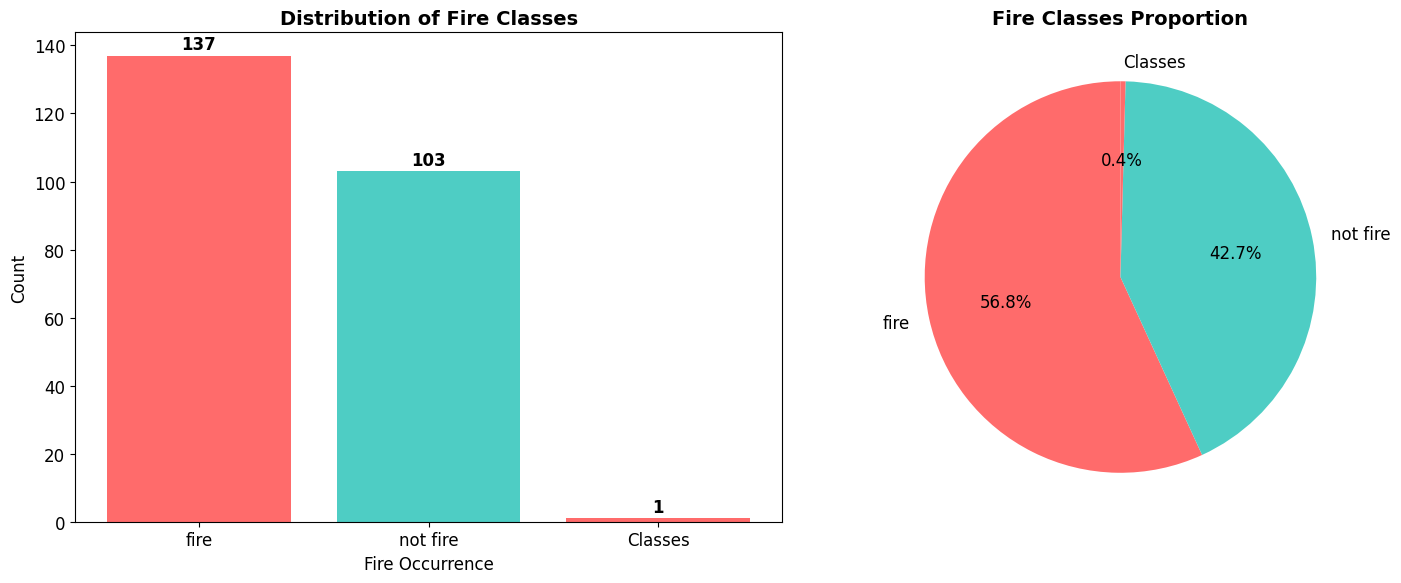

Class distribution:Classes
fire        137
not fire    103
Classes       1
Name: count, dtype: int64
Class balance ratio: 0.01


In [9]:
df = df.iloc[1:]

df.columns = df.columns.str.strip()
if 'Classes' in df.columns:
    df['Classes'] = df['Classes'].str.strip()
elif 'class' in df.columns:
    df['Classes'] = df['class'].str.strip()

print("Missing values per column:")
print(df.isnull().sum())
df = df.dropna(how='all', subset=df.columns[1:])

numerical_cols = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


print(f"Final dataset shape: {df.shape}")

print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
class_counts = df['Classes'].value_counts()
ax1.bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribution of Fire Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fire Occurrence')
ax1.set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 2, str(v), ha='center', fontweight='bold')

ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax2.set_title('Fire Classes Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class distribution:{class_counts}")
print(f"Class balance ratio: {class_counts.min()/class_counts.max():.2f}")

# Feature Correlation Analysis , Distribution Analysis and Box Plots

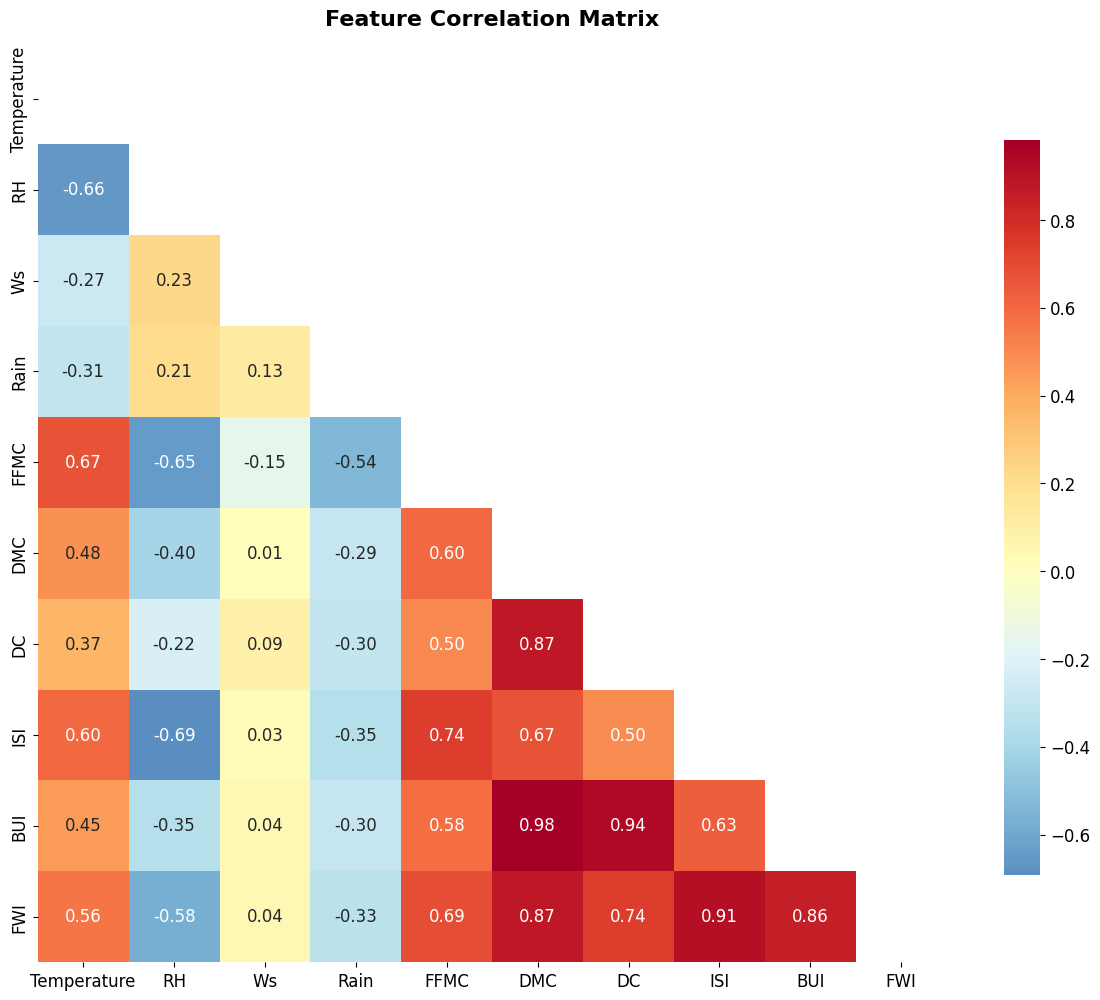

In [10]:
numeric_features = ['Temperature', 'RH', 'Ws', 'Rain']
if 'FFMC' in df.columns:
    numeric_features.extend(['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'])

correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

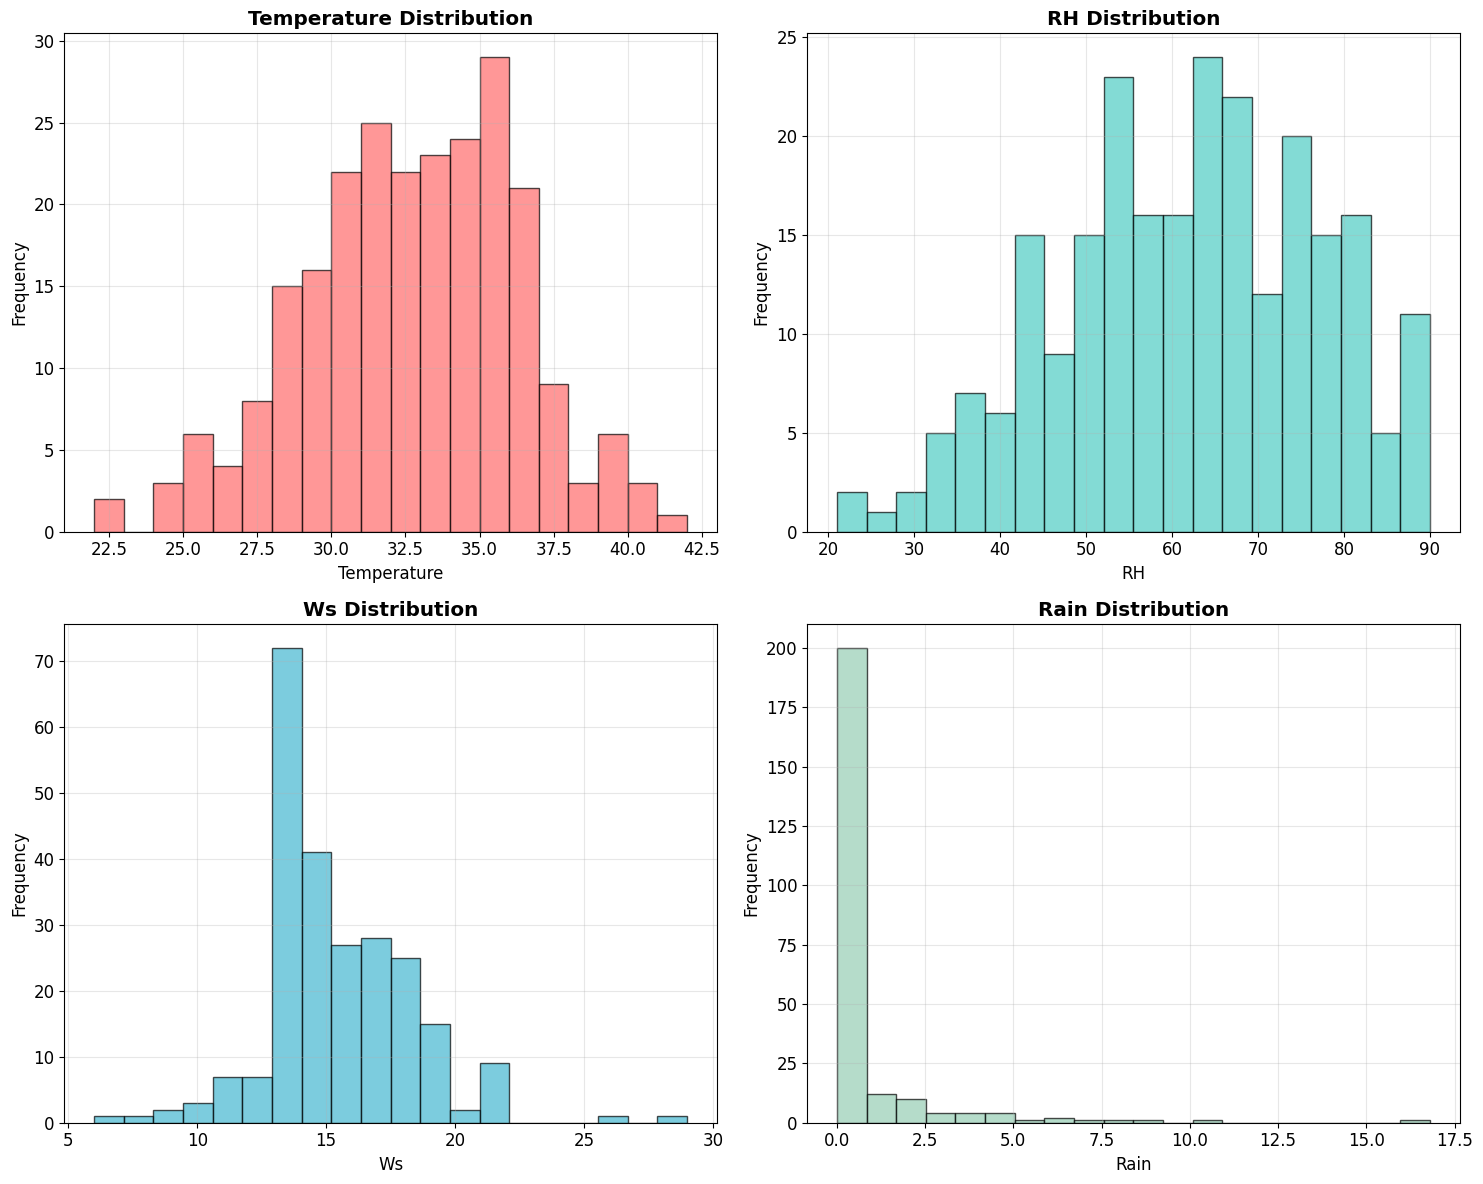

In [11]:
# Distribution Analysis of Weather Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

weather_features = ['Temperature', 'RH', 'Ws', 'Rain']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        axes[i].hist(df[feature], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
        axes[i].set_title(f'{feature} Distribution', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

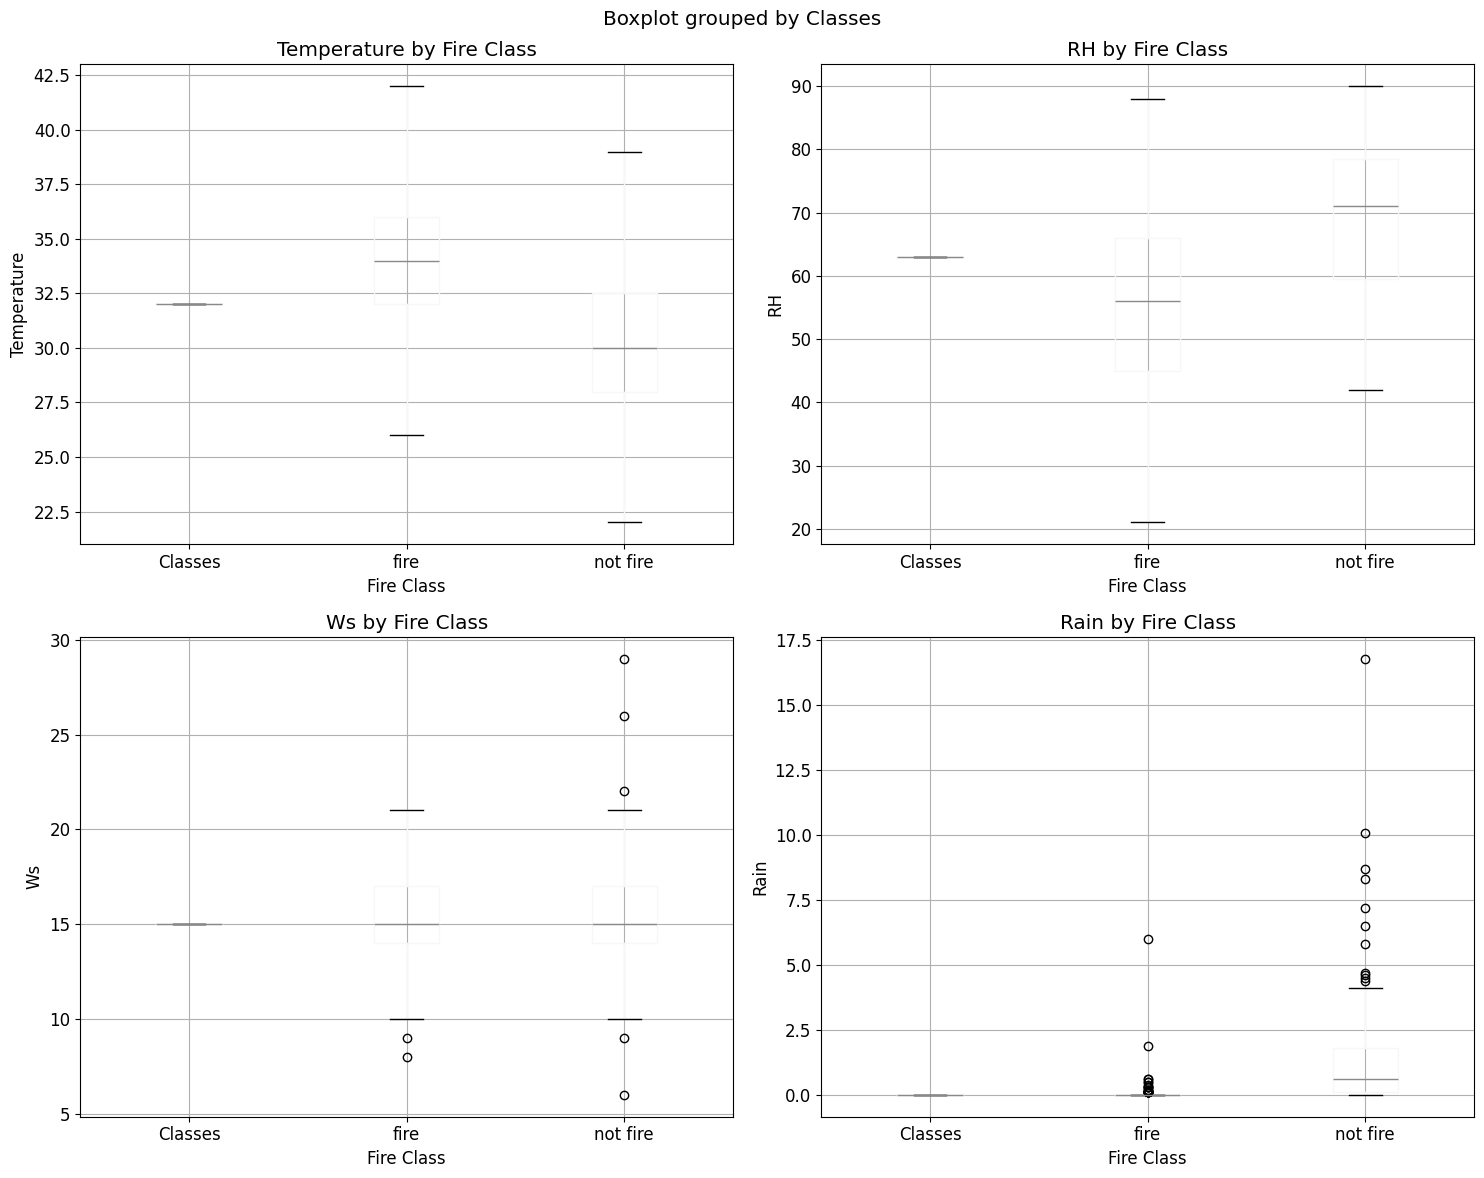

In [12]:
# Box Plots by Fire Class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        df.boxplot(column=feature, by='Classes', ax=axes[i])
        axes[i].set_title(f'{feature} by Fire Class')
        axes[i].set_xlabel('Fire Class')
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Statistical Analysis and Violin Plots

In [13]:
print("Statistical Analysis by Fire Class:")
print("="*50)

for feature in weather_features:
    if feature in df.columns:
        fire_data = df[df['Classes'] == 'fire'][feature]
        no_fire_data = df[df['Classes'] == 'not fire'][feature]

        t_stat, p_value = stats.ttest_ind(fire_data, no_fire_data)

        print(f"\n{feature}:")
        print(f"Fire days - Mean: {fire_data.mean():.2f}, Std: {fire_data.std():.2f}")
        print(f"No fire days - Mean: {no_fire_data.mean():.2f}, Std: {no_fire_data.std():.2f}")
        print(f"T-test p-value: {p_value:.4f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

Statistical Analysis by Fire Class:

Temperature:
Fire days - Mean: 33.80, Std: 2.92
No fire days - Mean: 30.09, Std: 3.37
T-test p-value: 0.0000
Significant difference: Yes

RH:
Fire days - Mean: 56.42, Std: 14.23
No fire days - Mean: 69.39, Std: 12.26
T-test p-value: 0.0000
Significant difference: Yes

Ws:
Fire days - Mean: 15.32, Std: 2.31
No fire days - Mean: 15.66, Std: 3.32
T-test p-value: 0.3522
Significant difference: No

Rain:
Fire days - Mean: 0.10, Std: 0.54
No fire days - Mean: 1.53, Std: 2.54
T-test p-value: 0.0000
Significant difference: Yes


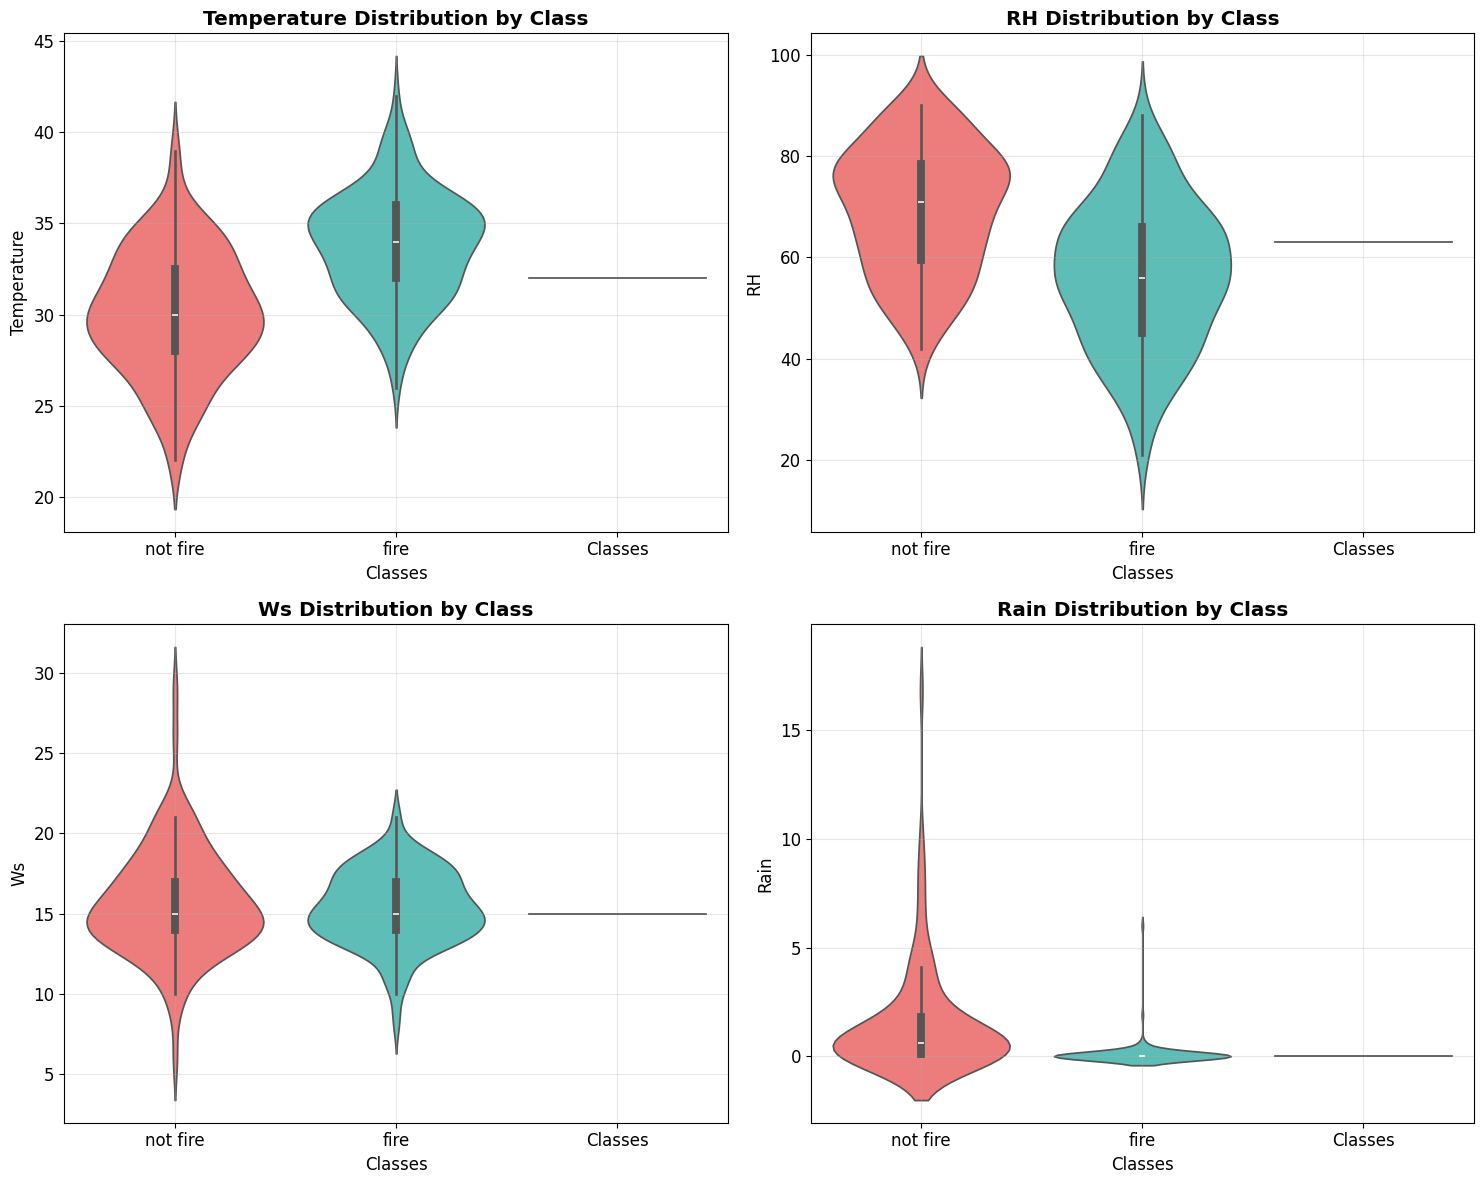

In [14]:
# Violin Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        sns.violinplot(data=df, x='Classes', y=feature, ax=axes[i], palette=['#FF6B6B', '#4ECDC4'])
        axes[i].set_title(f'{feature} Distribution by Class', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Engineering

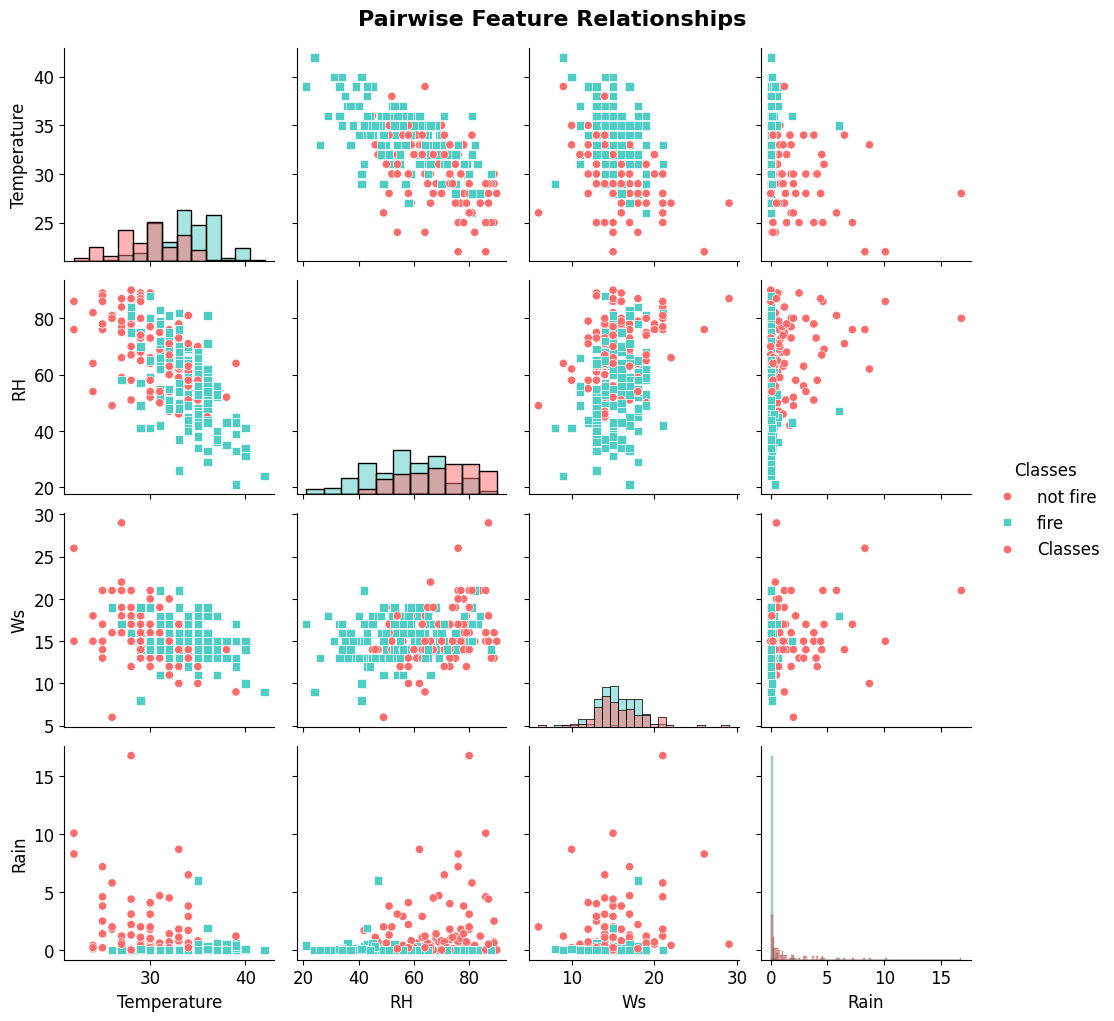

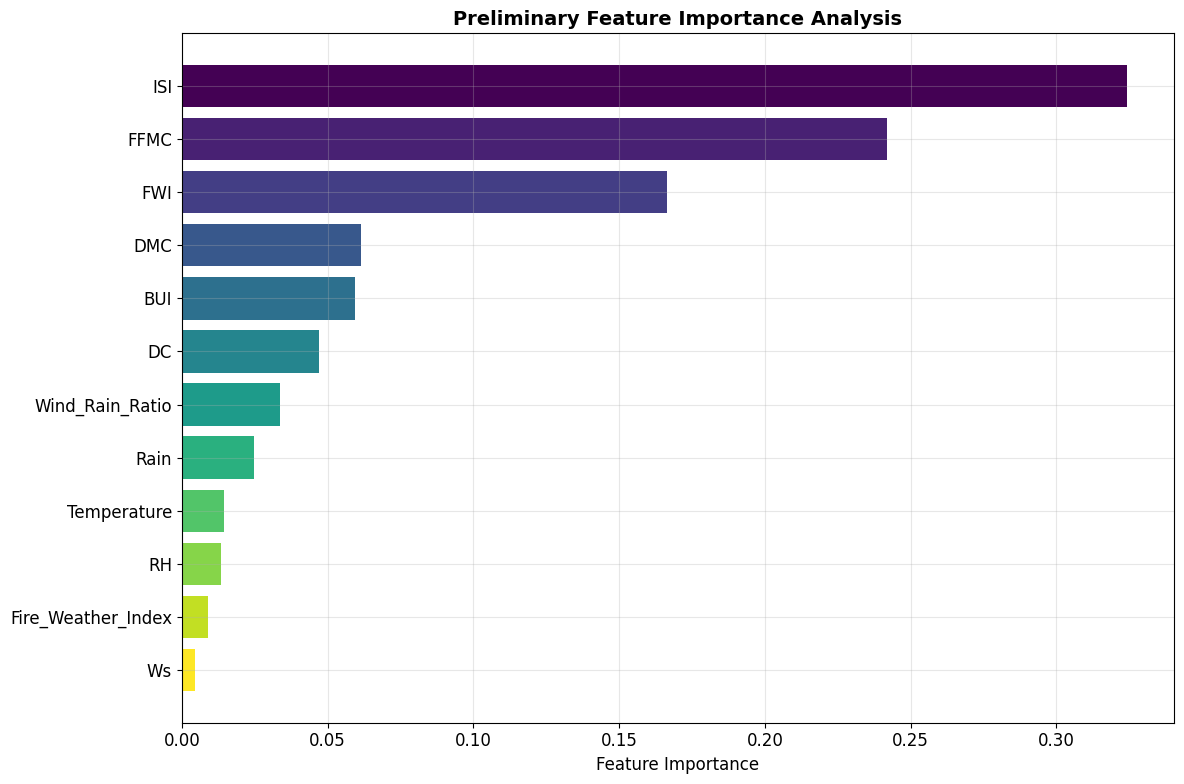

In [15]:
df['Temperature_Risk'] = pd.cut(df['Temperature'], bins=3, labels=['Low', 'Medium', 'High'])
df['RH_Risk'] = pd.cut(df['RH'], bins=3, labels=['Low', 'Medium', 'High'])
df['Wind_Rain_Ratio'] = df['Ws'] / (df['Rain'] + 0.01)  # Avoid division by zero
df['Fire_Weather_Index'] = (df['Temperature'] - df['RH']) * df['Ws'] / (df['Rain'] + 1)
le_temp = LabelEncoder()
le_rh = LabelEncoder()
df['Temperature_Risk_Encoded'] = le_temp.fit_transform(df['Temperature_Risk'])
df['RH_Risk_Encoded'] = le_rh.fit_transform(df['RH_Risk'])

# Pair Plots
key_features = ['Temperature', 'RH', 'Ws', 'Rain', 'Classes']
pair_data = df[key_features].copy()

g = sns.pairplot(pair_data, hue='Classes', palette=['#FF6B6B', '#4ECDC4'],
                 diag_kind='hist', markers=['o', 's'])
g.fig.suptitle('Pairwise Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
plt.show()
X_temp = df[numeric_features + ['Wind_Rain_Ratio', 'Fire_Weather_Index']].fillna(0)
y_temp = df['Classes']

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_temp)

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_encoded)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Preliminary Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Data Preparation for Machine Learning

In [21]:
feature_columns = ['Temperature', 'RH', 'Ws', 'Rain', 'Wind_Rain_Ratio', 'Fire_Weather_Index']
if 'FFMC' in df.columns:
    feature_columns.extend(['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'])

df_cleaned = df[df['Classes'] != 'Classes'].copy()

valid_classes = ['fire', 'not fire']
df_cleaned = df_cleaned[df_cleaned['Classes'].isin(valid_classes)].copy()

X = df_cleaned[feature_columns].fillna(0)
y = le_target.fit_transform(df_cleaned['Classes'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Model Performance Comparison Setup
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

Training set size: 192
Test set size: 48
Number of features: 12


# Cross-Validation Performance Evaluation

Cross-Validation Results:
Random Forest: 0.9741 (+/- 0.0653)
Gradient Boosting: 0.9634 (+/- 0.0629)
Extra Trees: 0.9636 (+/- 0.0621)
Logistic Regression: 0.9428 (+/- 0.0884)
SVM: 0.9375 (+/- 0.0898)
K-Nearest Neighbors: 0.8907 (+/- 0.0761)
Naive Bayes: 0.9534 (+/- 0.0680)
Neural Network: 0.9532 (+/- 0.0827)
Decision Tree: 0.9532 (+/- 0.0827)


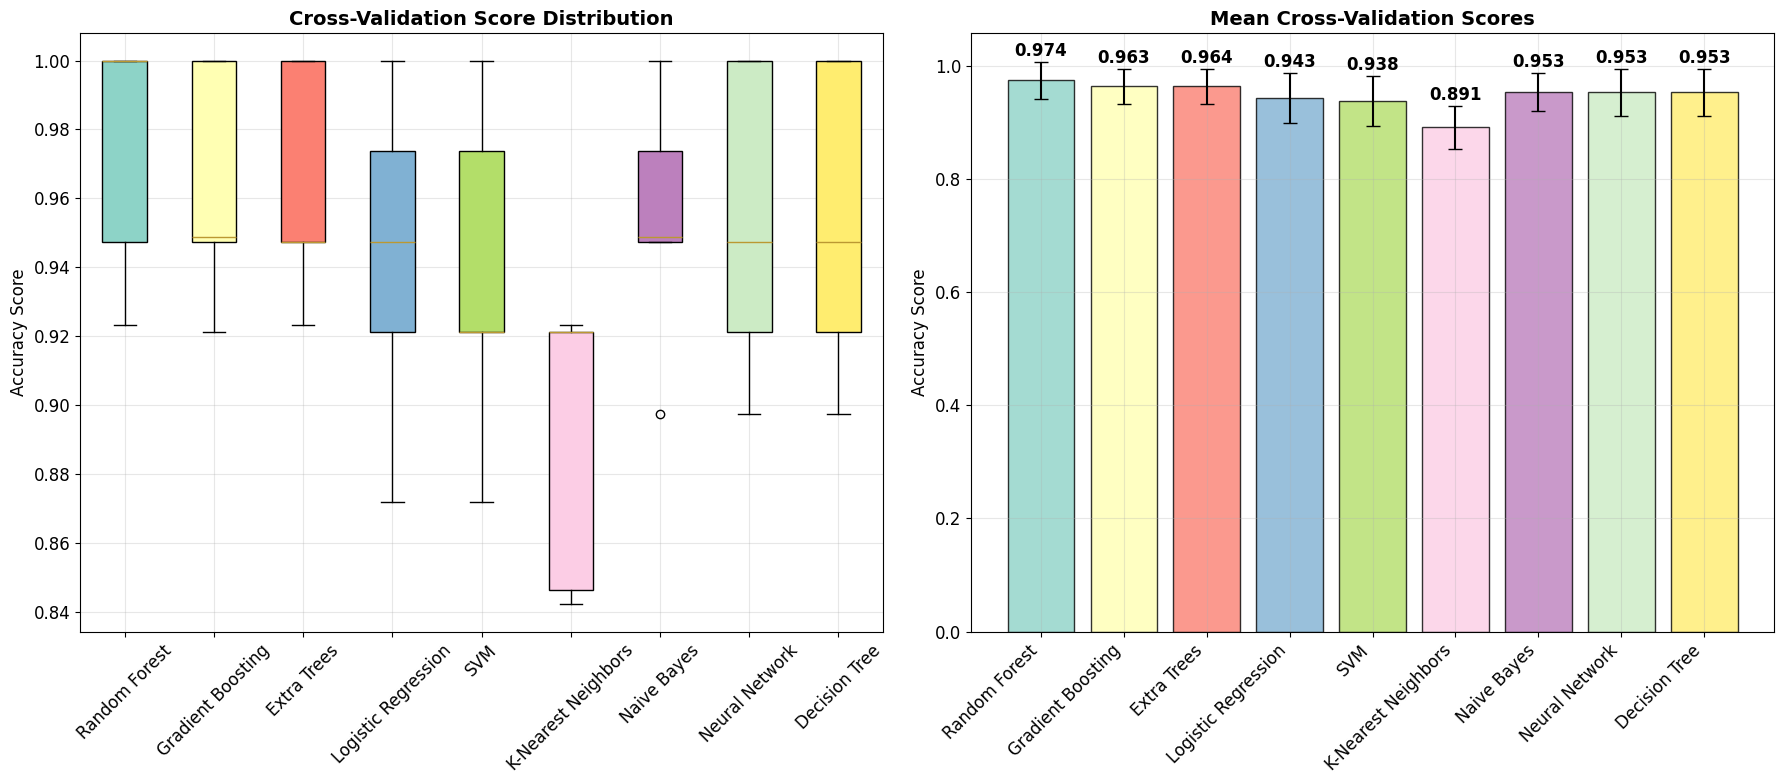

In [22]:
cv_results = {}
cv_scores = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-Validation Results:")
print("="*50)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    cv_results[name] = scores
    cv_scores[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max()
    }
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

cv_data = [cv_results[name] for name in models.keys()]
bp = ax1.boxplot(cv_data, labels=models.keys(), patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

means = [cv_scores[name]['mean'] for name in models.keys()]
stds = [cv_scores[name]['std'] for name in models.keys()]
model_names = list(models.keys())

bars = ax2.bar(range(len(models)), means, yerr=stds, capsize=5,
               color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Mean Cross-Validation Scores', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy Score')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    ax2.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Train and Evaluate Best Models

Test Set Performance:
Model                Accuracy   Precision  Recall     F1-Score  
----------------------------------------------------------------------
Random Forest        0.9583     0.9130     1.0000     0.9545    
Gradient Boosting    0.9792     0.9545     1.0000     0.9767    
Extra Trees          0.9583     0.9130     1.0000     0.9545    
Logistic Regression  0.9792     0.9545     1.0000     0.9767    
SVM                  0.8958     0.8636     0.9048     0.8837    
K-Nearest Neighbors  0.8750     0.8571     0.8571     0.8571    
Naive Bayes          0.8958     0.8636     0.9048     0.8837    
Neural Network       0.9792     0.9545     1.0000     0.9767    
Decision Tree        0.9792     0.9545     1.0000     0.9767    


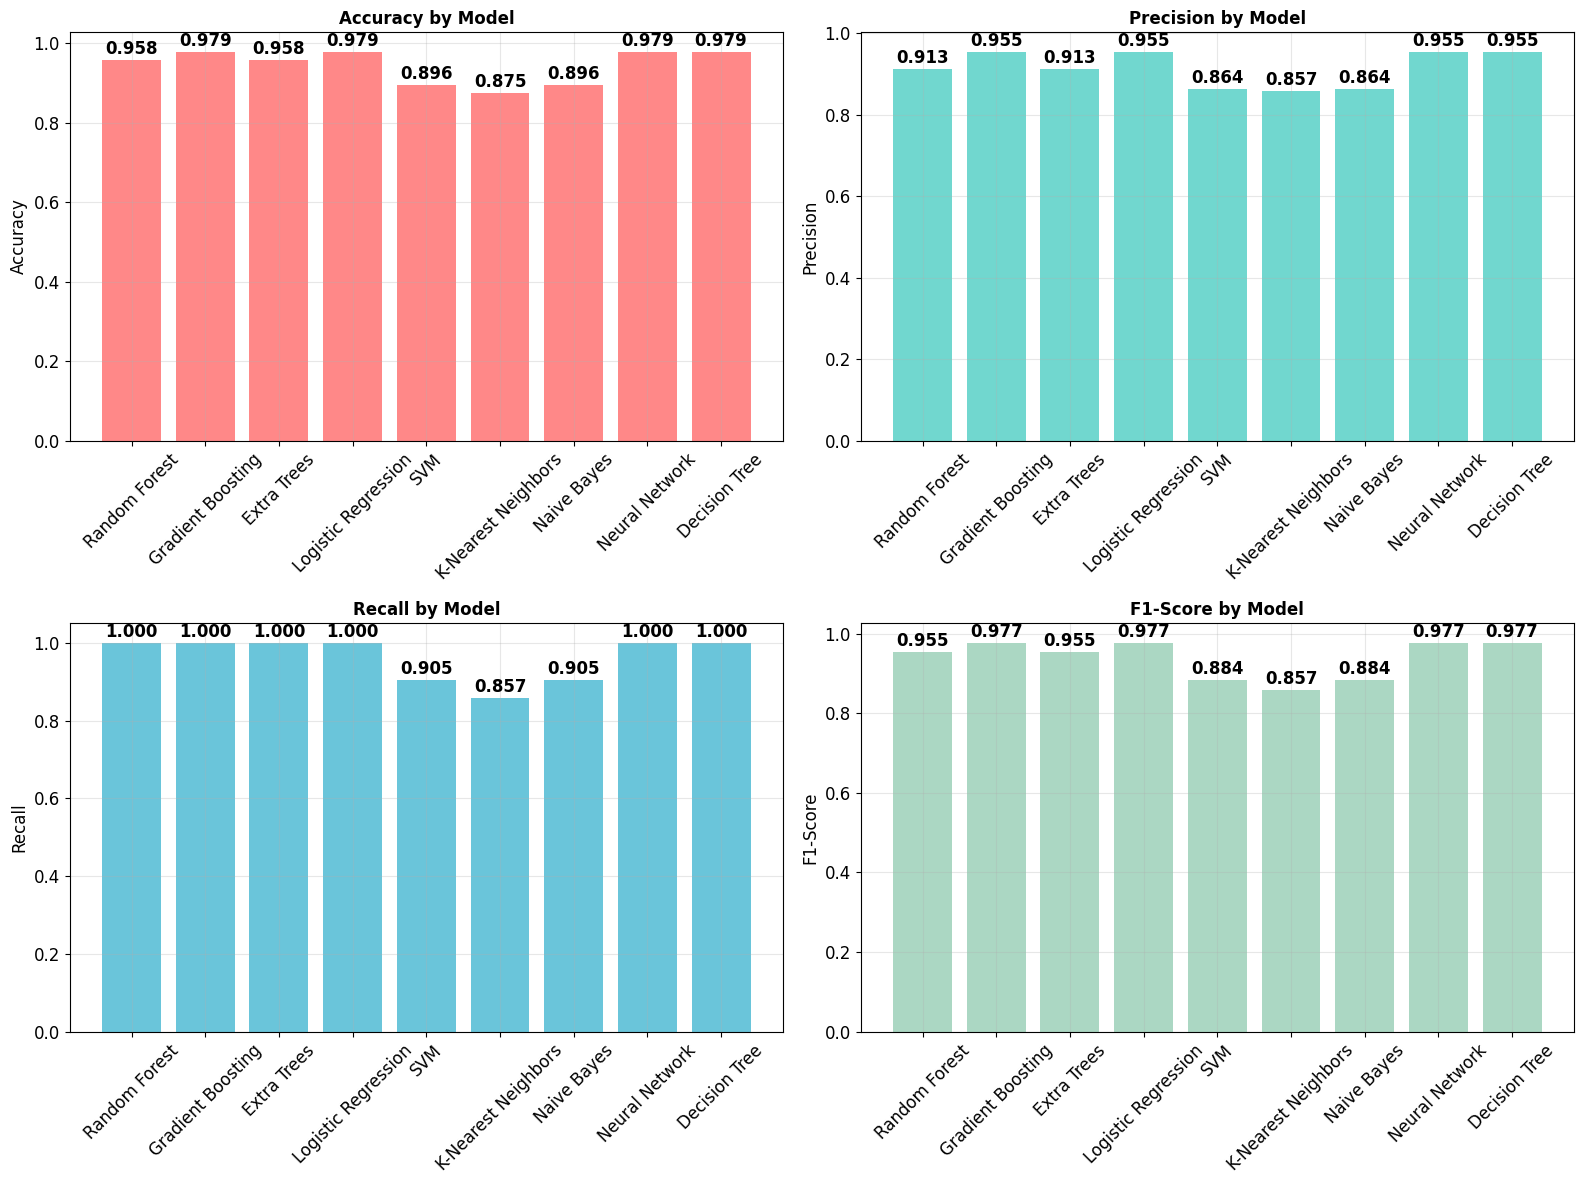

In [23]:
test_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

print("Test Set Performance:")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 70)

for name, results in test_results.items():
    print(f"{name:<20} {results['accuracy']:<10.4f} {results['precision']:<10.4f} "
          f"{results['recall']:<10.4f} {results['f1']:<10.4f}")

metrics_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [results['accuracy'] for results in test_results.values()],
    'Precision': [results['precision'] for results in test_results.values()],
    'Recall': [results['recall'] for results in test_results.values()],
    'F1-Score': [results['f1'] for results in test_results.values()]
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(metrics_df['Model'], metrics_df[metric], color=colors[i], alpha=0.8)
    ax.set_title(f'{metric} by Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix Analysis

Best performing model: Gradient Boosting
F1-Score: 0.9767


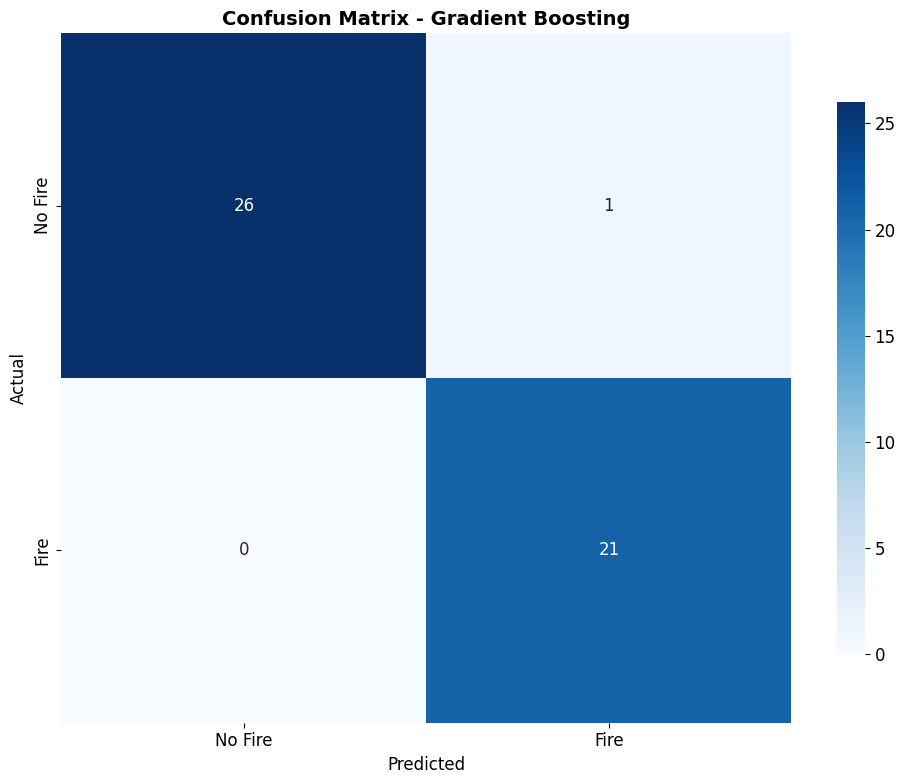

Confusion Matrix Analysis:
True Negatives: 26, False Positives: 1
False Negatives: 0, True Positives: 21
Sensitivity (Recall): 1.0000
Specificity: 0.9630


In [24]:
best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['f1'])
best_predictions = test_results[best_model_name]['predictions']

print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {test_results[best_model_name]['f1']:.4f}")

cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'],
            cbar_kws={'shrink': 0.8})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Confusion Matrix Analysis:")
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC Curve Analysis and Feature Importance Analysis

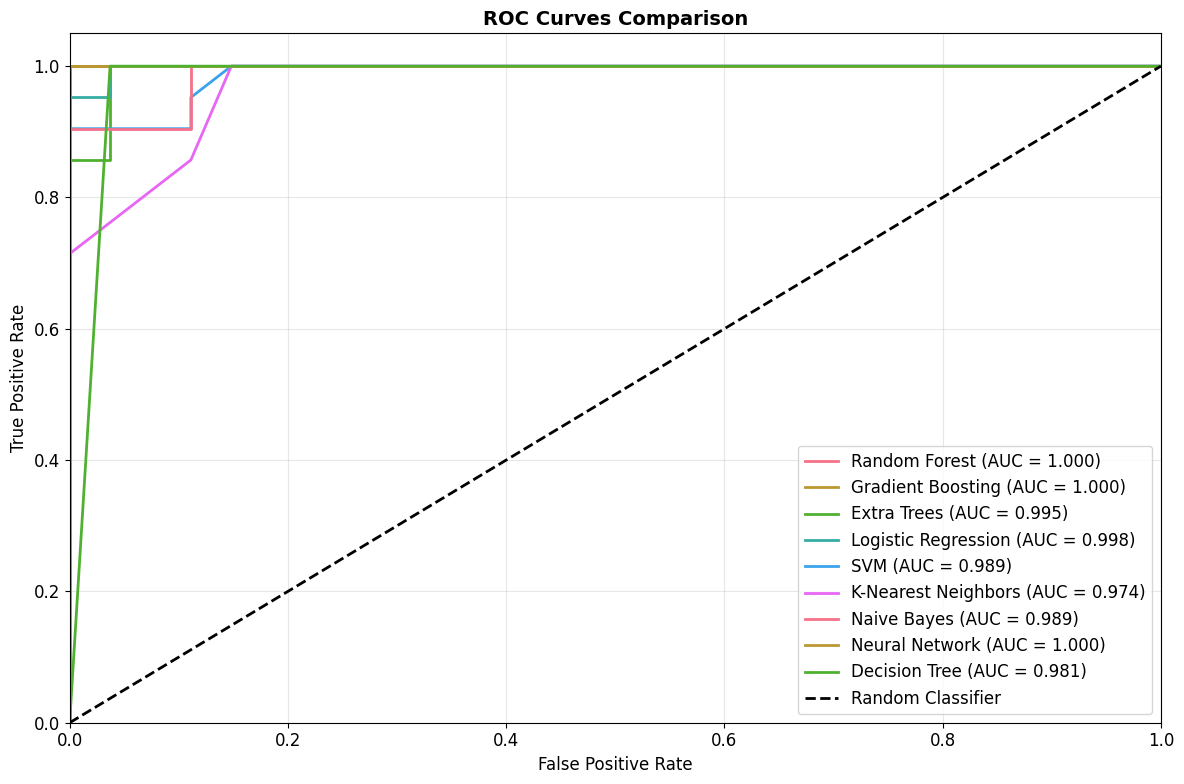

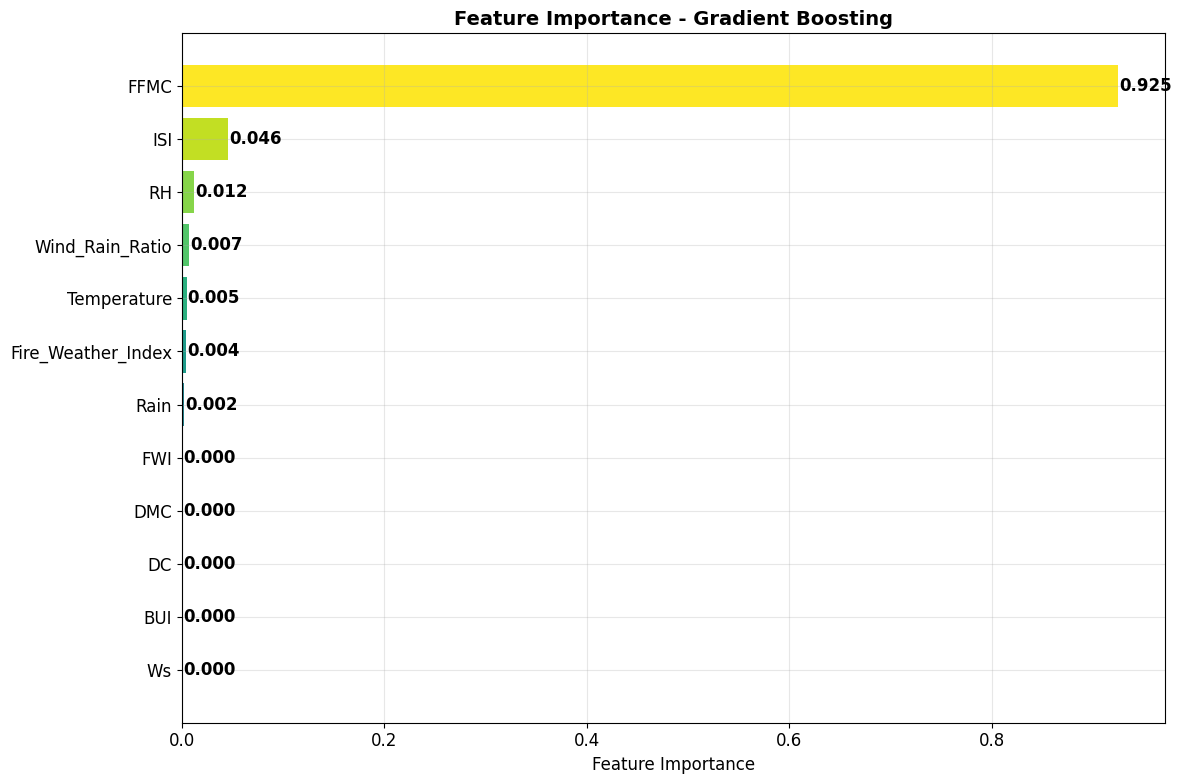

In [25]:
plt.figure(figsize=(12, 8))

for name, results in test_results.items():
    if results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2,
                label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Extra Trees']:
    best_model = models[best_model_name]

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    for i, v in enumerate(feature_importance['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Radar Chart

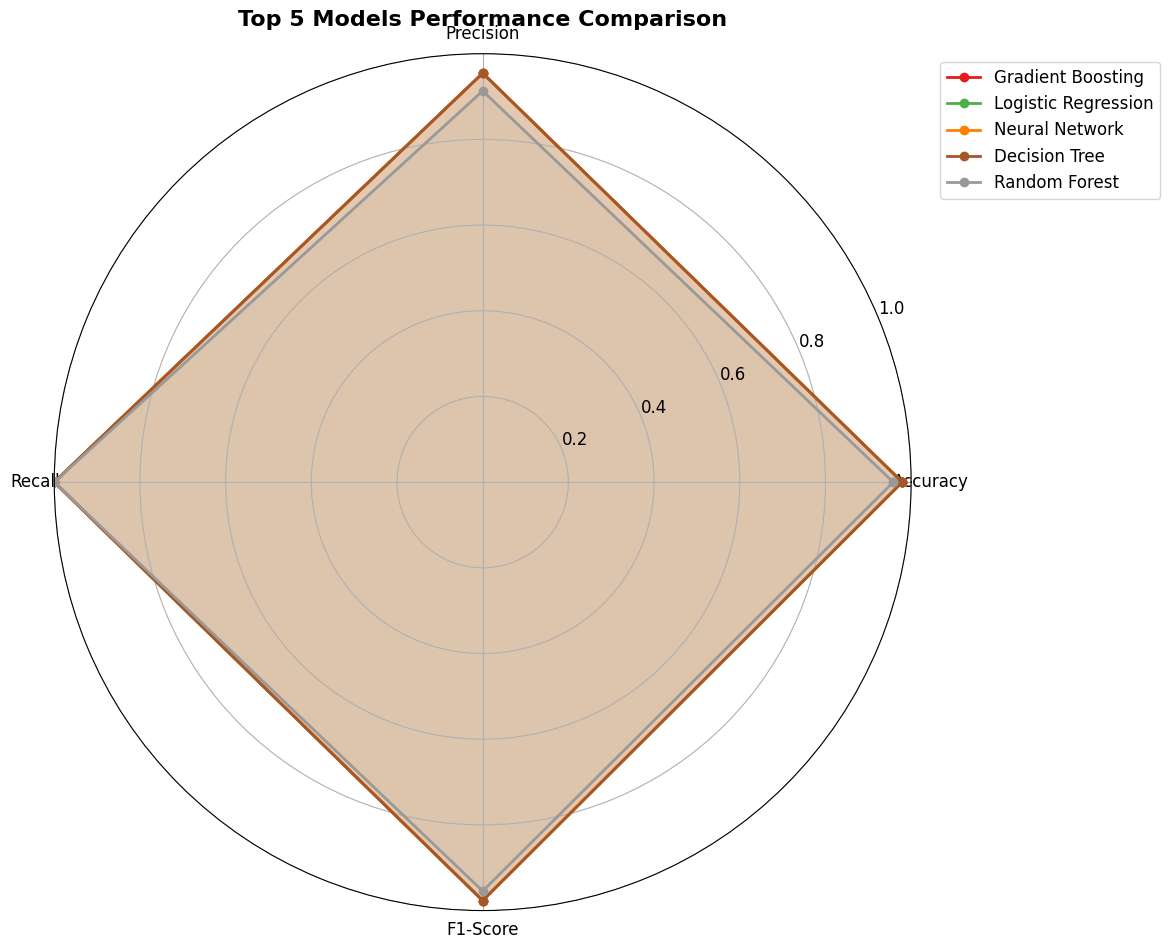

In [27]:
top_models = sorted(test_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:5]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
angles = [n / len(metrics) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

colors = plt.cm.Set1(np.linspace(0, 1, len(top_models)))

for i, (model_name, results) in enumerate(top_models):
    values = [results['accuracy'], results['precision'], results['recall'], results['f1']]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Top 5 Models Performance Comparison', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning for Best Model

In [28]:
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)
else:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
    base_model = models[best_model_name]

grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_scaled)

tuned_results = {
    'accuracy': accuracy_score(y_test, y_pred_tuned),
    'precision': precision_score(y_test, y_pred_tuned),
    'recall': recall_score(y_test, y_pred_tuned),
    'f1': f1_score(y_test, y_pred_tuned)
}

print("Tuned Model Performance:")
for metric, value in tuned_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Performing hyperparameter tuning for Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.9701
Tuned Model Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
